# Image Denoising with Deep CNNs
Use deep Convolutional Neural Networks (CNNs) with PyTorch, including investigating DnCNN and U-net architectures

## 1. Get started

In [1]:
%matplotlib notebook

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## 2. Creating noisy images of BSDS dataset with DataSet

Our goal is to use deep convolutional neural networks to learn the mapping $x_i$ → $y_i$ where $x_i$ are noisy images (our data/observations) and $y_i$ are clean images (our labels/ground-truth). We will consider the images of the BSDS dataset as our clean/ground-truth images: $y_i$. For each of them, we will generate noisy versions by adding white Gaussian noise: $x_i = y_i + w_i$ where $w_i$ is an image where each pixel is an independent realization of a zero-mean Gaussian distribution with standard deviation `σ = 30`. Since
images have different sizes, we will consider random crops of size of `180 × 180`.

In [16]:

dataset_root_dir = r'C:\Users\Vanshi\Desktop\denoising\Image-Denoising-with-Deep-CNNs-master\BSDS300\images'

In [9]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')   
        # random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [10]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

#### Build training set and testing set

In [17]:
train_set = NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))

In [18]:
x = test_set[12]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

<IPython.core.display.Javascript object>

image size is torch.Size([3, 320, 320]).


## 3. DnCNN

![](dncnn.png)

#### create a subclass NNRegressor that inherits from NeuralNetwork and implements the method criterion as being the MSE loss.

In [19]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

### Importance of weight initialization

#### without weight initialization

In [20]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

**Note:** In order to preserve the spatial feature dimensions between each successive layer of the network, we will have to use zero-padding by a suitable number of pixels that you have to determine.

In [21]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x) # 4-d
    # 3-d
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

<IPython.core.display.Javascript object>

Except for `DnCNN` with `D=0`, the others have **NO** residuals, showing only gray. It seems that it has gradient vanishment problem. So as the number of layers of a netwrok grows, it is more unlikely for a network to learn. In other words, the output is just like the input, and thus `x[0]-y[0]` is nothing.

As for the implication on backprop, since the output is the same as the input except for `DnCNN` with `D=0`, their gradient and weight update are the same as well, which means the network cannot learn well.

#### with weight initialization

In [22]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

In [23]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)
    
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

<IPython.core.display.Javascript object>

`DnCNN` with all different `D` have residual with non-zero values now. This is because He's initialization activates half of the neurons which avoid vanishing gradient in the ReLU. Now, since the output is different from the input, the gradient and weight update are different, enabling the network to learn properly.

### PSNR

A very classical (but controversial) way to compare the quality of restoration techniques is to use the PSNR (Peak Signal-to-Noise-Ratio) defined for images ranging in `[−1, 1]` as
$$
PSNR = 10\log_{10}\frac{4n}{\Vert y-d\Vert_2^2}
$$

where `d` is the desired ideal image, `y` is the estimate obtained from `x` and `n` the number of elements in the tensor. The PSNR measures in decibels (dB) the quality of the restoration: the higher the better.

#### create the sub-class DenoisingStatsManager that inherits from StatsManager and computes and averages PSNR between mini-batches

In [24]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [25]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

### train the `DnCNN`

In [28]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir=r"C:\Users\Vanshi\Desktop\denoising\Image-Denoising-with-Deep-CNNs-master\checkpoints\denoising1", perform_validation_during_training=True)

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

<IPython.core.display.Javascript object>

Start/Continue training from epoch 0
Epoch 1 | Time: 213.29s | Training Loss: 0.053112 | Evaluation Loss: 0.029960
Epoch 2 | Time: 182.99s | Training Loss: 0.025763 | Evaluation Loss: 0.022377
Epoch 3 | Time: 170.99s | Training Loss: 0.020659 | Evaluation Loss: 0.018895
Epoch 4 | Time: 164.58s | Training Loss: 0.018003 | Evaluation Loss: 0.016548
Epoch 5 | Time: 187.64s | Training Loss: 0.015994 | Evaluation Loss: 0.014809
Epoch 6 | Time: 195.94s | Training Loss: 0.014473 | Evaluation Loss: 0.013485
Epoch 7 | Time: 206.94s | Training Loss: 0.013178 | Evaluation Loss: 0.012364
Epoch 8 | Time: 216.08s | Training Loss: 0.012192 | Evaluation Loss: 0.011590
Epoch 9 | Time: 186.14s | Training Loss: 0.011476 | Evaluation Loss: 0.010981
Epoch 10 | Time: 184.51s | Training Loss: 0.010700 | Evaluation Loss: 0.010410
Epoch 11 | Time: 190.99s | Training Loss: 0.010175 | Evaluation Loss: 0.009826
Epoch 12 | Time: 175.48s | Training Loss: 0.009528 | Evaluation Loss: 0.009436
Epoch 13 | Time: 179.04s

### Performance evaluation

In [30]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[12]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

<IPython.core.display.Javascript object>

There are some area lost the information. Besides, although the denoise image looks great, based on the PSNR, we can know that noise still exists.

### parameters of `DnCNN`

In [31]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

* number of parameters:

The first layer has `64 x 3 x 3 x 3` parameters. The middle `D` layers have `64 x 64 x 3 x 3 x D` parameters. The last layer has `3 x 64 x 3 x 3` parameters. Hence, there are total `3456 + 36864 x D` parameters.

* receptive field:

Based on the equation to compute the receptive field $2^{k-l+1}\times padding\ size$ where `k` and `l` are the number of the pooling and unpooling layers respectively, we can know that since there are no pooling and unpooling layers, each layer increase the width and height of receptive field by $2^{0-0+1}=2$. Besides, the receptive field of the input layer is `1`. We can infer that the receptive field of `DnCNN(D)` is $(1+2\times (D+2))^2$. Take `D=6` for example, the receptive field is $17^2$.

### Denoising literature claims that for reducing Gaussian noise of standard deviation σ = 30 efficiently, a pixel should be influenced by at least 33 × 33 pixels. How large D (how deep) should DnCNN be to satisfy this constraint?

Since receptive field is $(1+2\times (D+2)) \times (1+2\times (D+2))$, we can infer that $1+2\times (D+2) = 33$ and obtain $D=14$. For the number of parameters, it would be $3456 + 36864 \times 14 = 519552$. Besides, we can infer that as the number of parameters increases, the computation time would increase as well.

## 4. U-net like CNNs

![](udncnn.png)

In [32]:
class UDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []
        idx_buff = []
        shape_buff = []
        for i in range(D//2-1):
            shape_buff.append(h.shape)
            h, idx = F.max_pool2d(F.relu(self.bn[i](self.conv[i+1](h))), 
                                  kernel_size=(2,2), return_indices=True)
            h_buff.append(h)
            idx_buff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        for i in range(D//2+1, D):
            j = i - (D//2 + 1) + 1
            h = F.max_unpool2d(F.relu(self.bn[i](self.conv[i+1]((h+h_buff[-j])/np.sqrt(2)))), 
                               idx_buff[-j], kernel_size=(2,2), output_size=shape_buff[-j])
        y = self.conv[D+1](h) + x
        return y

### train the `UDnCNN`

In [33]:
lr = 1e-3
net = UDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/denoising2", perform_validation_during_training=True)

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

<IPython.core.display.Javascript object>

Start/Continue training from epoch 0
Epoch 1 | Time: 69.70s | Training Loss: 0.046810 | Evaluation Loss: 0.032035
Epoch 2 | Time: 81.16s | Training Loss: 0.029189 | Evaluation Loss: 0.025288
Epoch 3 | Time: 75.77s | Training Loss: 0.024754 | Evaluation Loss: 0.021876
Epoch 4 | Time: 70.30s | Training Loss: 0.022007 | Evaluation Loss: 0.019914
Epoch 5 | Time: 69.69s | Training Loss: 0.019862 | Evaluation Loss: 0.017879
Epoch 6 | Time: 68.91s | Training Loss: 0.018306 | Evaluation Loss: 0.017447
Epoch 7 | Time: 75.60s | Training Loss: 0.016894 | Evaluation Loss: 0.015479
Epoch 8 | Time: 78.87s | Training Loss: 0.015454 | Evaluation Loss: 0.014498
Epoch 9 | Time: 80.52s | Training Loss: 0.014236 | Evaluation Loss: 0.013620
Epoch 10 | Time: 74.97s | Training Loss: 0.013816 | Evaluation Loss: 0.012883
Epoch 11 | Time: 74.30s | Training Loss: 0.012767 | Evaluation Loss: 0.012335
Epoch 12 | Time: 69.10s | Training Loss: 0.012078 | Evaluation Loss: 0.011453
Epoch 13 | Time: 73.23s | Training L

### parameters of `UDnCNN`

In [22]:
for name, param in exp2.net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

Since pooling and unppooling do not have learnable parameters, the number of parameters of `UDnCNN` is the same as that of `DnCNN`, which is `3456 + 36864 x D`.

The receptive field of `UDnCNN` would be $(1+\sum_{i=1}^{D/2}2^i+2\times 2^{D/2}+\sum_{i=1}^{D/2-1}2^i+2)^2$. For the case `D=6`, the receptive field would be $(1+(2+4+8)+(2\times 8)+(4+2)+2)^2=39^2$.

I do not believe `UDnCNN` would beat `DnCNN` because `UDnCNN` uses pooling which might lose some information. Based on the training PSNR, `UDnCNN` indeed is a bit worse than `DnCNN`.

### Performace comparison between `DnCNN` and `UDnCNN`

In [35]:
# DnCNN
exp1.evaluate()

{'loss': 0.005038262577727437, 'PSNR': tensor(29.0453)}

In [36]:
# UDnCNN
exp2.evaluate()

{'loss': 0.005885699093341828, 'PSNR': tensor(28.3592)}

## 5. U-net like CNNs with dilated convolutions

Though pooling layers increase the receptive field, they lose information about exact locations. This is desired for classification, but for denoising this decreases performance. An alternative to pooling is to use dilated convolutions (sometimes refer to the à trous algorithm, meaning with holes). Instead of increasing the receptive field by reducing the feature spatial dimensions by a factor 2 after each convolution, the filters are dilated by a factor 2. In order to maintain the same number of parameters, the dimensions are increased by injecting “holes” between each rows and columns of the filter. Please, refer to the following figure:

![](dilated_conv.png)

In theory, dilated convolutions should not be slower than standard convolutions, but for some reasons there are when using the default PyTorch backend implementation. For this reason, add the two instructions `torch.backends.cudnn.benchmark=True` and `torch.backends.cudnn.benchmark=False`, before and after running any dilated convolutions. For more details, see the discussion here: [https://github.com/pytorch/pytorch/issues/15054](https://github.com/pytorch/pytorch/issues/15054).

In [37]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # holes and dilations for convolution layers
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            h_buff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        y = self.conv[D+1](h) + x
        return y

### train the `DUDnCNN`

In [38]:
lr = 1e-3
net = DUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/denoising3", perform_validation_during_training=True)

In [39]:
exp3

Net(DUDnCNN(
  (mse): MSELoss()
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (3-4): 2 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn): ModuleList(
    (0-5): 6 x BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
  )
))
TrainSet(NoisyBSDSDataset(mode=train, image_size=(180, 180), sigma=30))
ValSet(NoisyBSDSDataset(mode=test, image_size=(320, 320), sigma=30))
Optimizer(Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
  

In [40]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

<IPython.core.display.Javascript object>

Start/Continue training from epoch 0
Epoch 1 | Time: 206.97s | Training Loss: 0.055153 | Evaluation Loss: 0.025369
Epoch 2 | Time: 204.28s | Training Loss: 0.020763 | Evaluation Loss: 0.017734
Epoch 3 | Time: 203.66s | Training Loss: 0.016245 | Evaluation Loss: 0.014884
Epoch 4 | Time: 205.56s | Training Loss: 0.014177 | Evaluation Loss: 0.013154
Epoch 5 | Time: 206.23s | Training Loss: 0.012694 | Evaluation Loss: 0.011990
Epoch 6 | Time: 205.09s | Training Loss: 0.011561 | Evaluation Loss: 0.011079
Epoch 7 | Time: 204.23s | Training Loss: 0.011037 | Evaluation Loss: 0.010473
Epoch 8 | Time: 205.70s | Training Loss: 0.010447 | Evaluation Loss: 0.009901
Epoch 9 | Time: 205.95s | Training Loss: 0.009951 | Evaluation Loss: 0.009478
Epoch 10 | Time: 205.09s | Training Loss: 0.009290 | Evaluation Loss: 0.009076
Epoch 11 | Time: 205.78s | Training Loss: 0.009012 | Evaluation Loss: 0.008739
Epoch 12 | Time: 207.01s | Training Loss: 0.008976 | Evaluation Loss: 0.008567
Epoch 13 | Time: 209.66s

### Performance comparison among `DnCNN`, `UDnCNN`, and `DUDnCNN`

In [29]:
# DnCNN
exp1.evaluate()

{'loss': 0.005134490570053458, 'PSNR': tensor(28.9662)}

In [30]:
# UDnCNN
exp2.evaluate()

{'loss': 0.005955553036183119, 'PSNR': tensor(28.3076)}

In [31]:
# DUDnCNN
exp3.evaluate()

{'loss': 0.004931802665814757, 'PSNR': tensor(29.1349)}

<IPython.core.display.Javascript object>


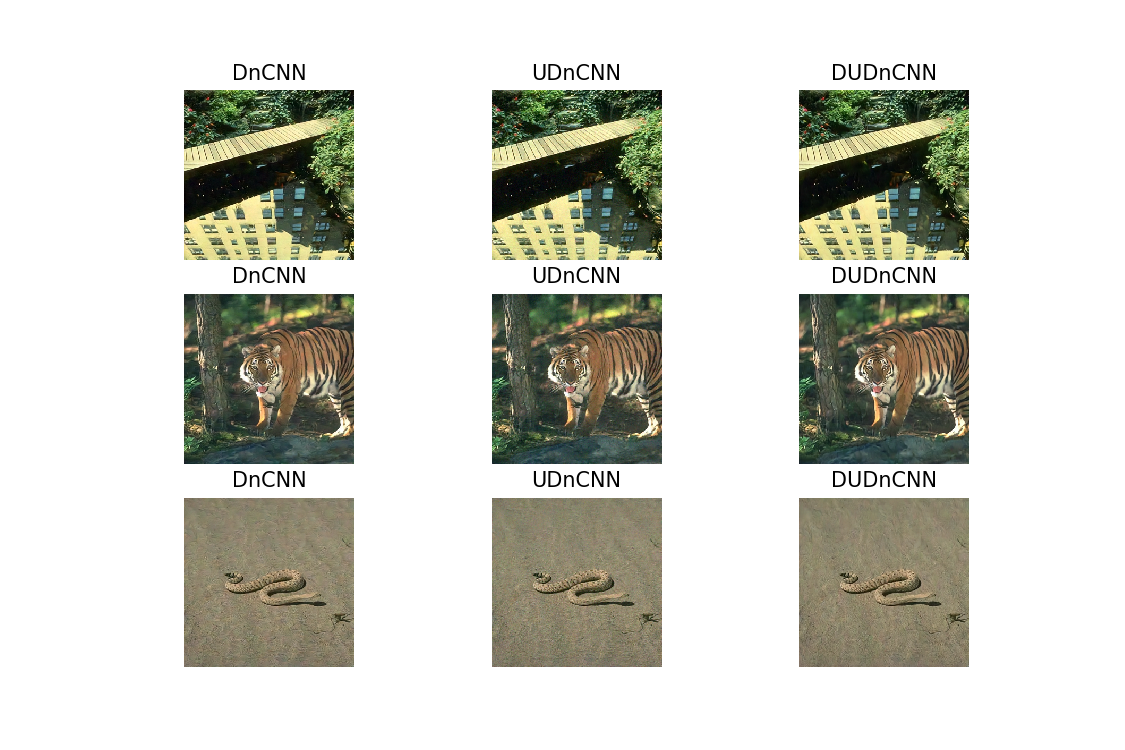

In [32]:
num = 3
img = []
nets = [exp1.net, exp2.net, exp3.net]
titles = ['DnCNN', 'UDnCNN', 'DUDnCNN']

for i in range(num):
    x, _ = test_set[7*i+7]
    x = x.unsqueeze(0).to(device)
    img.append(x)

fig, axes = plt.subplots(nrows=num, ncols=3, figsize=(9,6), sharex='all', sharey='all')
for i in range(num):
    for j in range(len(nets)):
        model = nets[j].to(device)
        model.eval()
        with torch.no_grad():
            y = model.forward(img[i])

        myimshow(y[0], ax=axes[i][j])
        axes[i][j].set_title(f'{titles[j]}')

### parameters of `DUDnCNN`

In [33]:
exp3.net

DUDnCNN(
  (mse): MSELoss()
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn): ModuleList(
    (0): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
  

In [34]:
for name, param in exp3.net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

* number of parameters:  
The number of parameters of `DUDnCNN` is the same as that of `UDnCNN` and `DnCNN` because dilated convolution does not have extra parameters, compared with original convolution. So, the number of parameters of `DUDnCNN(D)` is `3456 + 36864 x D`

* receptive field:  
Since the padding size is not the same for each layer as the `UDnCNN`, the receptive field for `DUDnCNN` is $(1+2+\sum_{i=1}^{D/2}2^i\times 2^{i-1}+2^{D/2}\times 2^{D/2-1}+\sum_{i=1}^{D/2-1}2^i\times 2^{i-1}+2)^2$. For `DUDnCNN(6)`, its receptive field is $89^2$. **Not sure for this**